# Alibi Overview Example

This notebook aims to demonstrate each of the explainers Alibi provides on the same model and dataset. Unfortunately, this isn't possible as white-box neural network methods exclude tree-based white-box methods. Hence we will train both a neural network(TensorFlow) and a random forest model on the same dataset and apply the full range of explainers to see what insights we can obtain.

The results and code from this notebook are used in the [documentation overview](../overview/high_level.md).

This notebook requires the seaborn package for visualization which can be installed via pip:

<div class="alert alert-info">
Note
    
To enusre all dependencies are met for this example, you may need to run
    
```bash
pip install alibi[all]
```

</div>

In [ ]:
!pip install seaborn

In [3]:
import requests
from io import BytesIO, StringIO
from io import BytesIO
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
import os.path

import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)

FROM_SCRATCH = False
TF_MODEL_FNAME = 'tf-clf-wine'
RFC_FNAME = 'rfc-wine'
ENC_FNAME = 'wine_encoder'
DEC_FNAME = 'wine_decoder'

## Preparing the data.

We're using the [wine-quality](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/) dataset, a numeric tabular dataset containing features that refer to the chemical composition of wines and quality ratings. To make this a simple classification task, we bucket all wines with ratings greater than five as good, and the rest we label bad. We also normalize all the features.

In [4]:
def fetch_wine_ds():
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    resp = requests.get(url, timeout=2)
    resp.raise_for_status()
    string_io = StringIO(resp.content.decode('utf-8'))
    return pd.read_csv(string_io, sep=';')

In [5]:
df = fetch_wine_ds()

In [7]:
df['class'] = 'bad'
df.loc[(df['quality'] > 5), 'class'] = 'good'

features = [
    'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
    'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
    'pH', 'sulphates', 'alcohol'
]

df['good'] = 0
df['bad'] = 0
df.loc[df['class'] == 'good', 'good'] = 1
df.loc[df['class'] == 'bad', 'bad'] = 1

data = df[features].to_numpy()
labels = df[['class','good', 'bad']].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=0)
X_train, X_test = X_train.astype('float32'), X_test.astype('float32')
y_train_lab, y_test_lab = y_train[:, 0], y_test[:, 0]
y_train, y_test = y_train[:, 1:].astype('float32'), y_test[:, 1:].astype('float32')

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

### Select good wine instance 

We partition the dataset into good and bad portions and select an instance of interest. I've chosen it to be a good quality wine. 

**Note** that bad wines are class 1 and correspond to the second model output being high, whereas good wines are class 0 and correspond to the first model output being high.

In [8]:
bad_wines = np.array([a for a, b in zip(X_train, y_train) if b[1] == 1])
good_wines = np.array([a for a, b in zip(X_train, y_train) if b[1] == 0])
x = np.array([[9.2, 0.36, 0.34, 1.6, 0.062, 5., 12., 0.99667, 3.2, 0.67, 10.5]]) # prechosen instance

## Training models

### Creating an Autoencoder

For some of the explainers, we need an autoencoder to check whether example instances are close to the training data distribution or not.

In [9]:
from tensorflow.keras.layers import Dense
from tensorflow import keras


ENCODING_DIM = 7
BATCH_SIZE = 64
EPOCHS = 100


class AE(keras.Model):
    def __init__(self, encoder: keras.Model, decoder: keras.Model, **kwargs) -> None:
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x: tf.Tensor, **kwargs):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    
def make_ae():
    len_input_output = X_train.shape[-1]

    encoder = keras.Sequential()
    encoder.add(Dense(units=ENCODING_DIM*2, activation="relu", input_shape=(len_input_output, )))
    encoder.add(Dense(units=ENCODING_DIM, activation="relu"))

    decoder = keras.Sequential()
    decoder.add(Dense(units=ENCODING_DIM*2, activation="relu", input_shape=(ENCODING_DIM, )))
    decoder.add(Dense(units=len_input_output, activation="linear"))

    ae = AE(encoder=encoder, decoder=decoder)

    ae.compile(optimizer='adam', loss='mean_squared_error')
    history = ae.fit(
        scaler.transform(X_train), 
        scaler.transform(X_train), 
        batch_size=BATCH_SIZE, 
        epochs=EPOCHS, 
        verbose=False,)

    # loss = history.history['loss']
    # plt.plot(loss)
    # plt.xlabel('Epoch')
    # plt.ylabel('MSE-Loss')

    ae.encoder.save(f'{ENC_FNAME}.h5')
    ae.decoder.save(f'{DEC_FNAME}.h5')
    return ae

def load_ae_model():
    encoder = load_model(f'{ENC_FNAME}.h5')
    decoder = load_model(f'{DEC_FNAME}.h5')
    return AE(encoder=encoder, decoder=decoder)

### Random Forest Model

We need a tree-based model to get results for the tree SHAP explainer. Hence we train a random forest on the wine-quality dataset.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score


def make_rfc():
    rfc = RandomForestClassifier(n_estimators=50)
    rfc.fit(scaler.transform(X_train), y_train_lab)
    y_pred = rfc.predict(scaler.transform(X_test))

    print('accuracy_score:', accuracy_score(y_pred, y_test_lab))
    print('f1_score:', f1_score(y_test_lab, y_pred, average=None))

    joblib.dump(rfc, f"{RFC_FNAME}.joblib")
    return rfc


def load_rfc_model():
    return joblib.load(f"{RFC_FNAME}.joblib")

### Tensorflow Model

Finally, we also train a TensorFlow model.

In [11]:
from tensorflow import keras
from tensorflow.keras import layers 

def make_tf_model():
    inputs = keras.Input(shape=X_train.shape[1])
    x = layers.Dense(6, activation="relu")(inputs)
    outputs = layers.Dense(2, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
    history = model.fit(
        scaler.transform(X_train), 
        y_train,
        epochs=30, 
        verbose=False, 
        validation_data=(scaler.transform(X_test), y_test),
    )

    y_pred = model(scaler.transform(X_test)).numpy().argmax(axis=1)
    print('accuracy_score:', accuracy_score(y_pred, y_test.argmax(axis=1)))
    print('f1_score:', f1_score(y_pred, y_test.argmax(axis=1), average=None))

    model.save(f'{TF_MODEL_FNAME}.h5')
    return model

def load_tf_model():
    return load_model(f'{TF_MODEL_FNAME}.h5')

### Load/Make models

We save and load the same models each time to ensure stable results. If they don't exist we create new ones. If you want to generate new models on each notebook run, then set `FROM_SCRATCH=True`.

In [12]:
if FROM_SCRATCH or not os.path.isfile(f'{TF_MODEL_FNAME}.h5'):
    model = make_tf_model()
    rfc = make_rfc()
    ae = make_ae()
else:
    rfc = load_rfc_model()
    model = load_tf_model() 
    ae = load_ae_model()

accuracy_score: 0.74
f1_score: [0.75471698 0.72340426]
accuracy_score: 0.815
f1_score: [0.8        0.82790698]


## Util functions

These are utility functions for exploring results. The first shows two instances of the data side by side and compares the difference. We'll use this to see how the counterfactuals differ from their original instances. The second function plots the importance of each feature. This will be useful for visualizing the attribution methods.

In [13]:
def compare_instances(x, cf):
    """
    Show the difference in values between two instances.
    """
    x = x.astype('float64')
    cf = cf.astype('float64')
    for f, v1, v2 in zip(features, x[0], cf[0]):
        print(f'{f:<25} instance: {round(v1, 3):^10} counter factual: {round(v2, 3):^10} difference: {round(v1 - v2, 7):^5}')

def plot_importance(feat_imp, feat_names, class_idx, **kwargs):
    """
    Create a horizontal barchart of feature effects, sorted by their magnitude.
    """
    
    df = pd.DataFrame(data=feat_imp, columns=feat_names).sort_values(by=0, axis='columns')
    feat_imp, feat_names = df.values[0], df.columns
    fig, ax = plt.subplots(figsize=(10, 5))
    y_pos = np.arange(len(feat_imp))
    ax.barh(y_pos, feat_imp)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feat_names, fontsize=15)
    ax.invert_yaxis()
    ax.set_xlabel(f'Feature effects for class {class_idx}', fontsize=15)
    return ax, fig

## Local Feature Attribution

### Integrated Gradients

The integrated gradients (IG) method computes the attribution of each feature by integrating the model partial derivatives along a path from a baseline point to the instance. This accumulates the changes in the prediction that occur due to the changing feature values. These accumulated values represent how each feature contributes to the prediction for the instance of interest.

We illustrate the application of IG to the instance of interest.

(<AxesSubplot:xlabel='Feature effects for class "good"'>,
 <Figure size 720x360 with 1 Axes>)

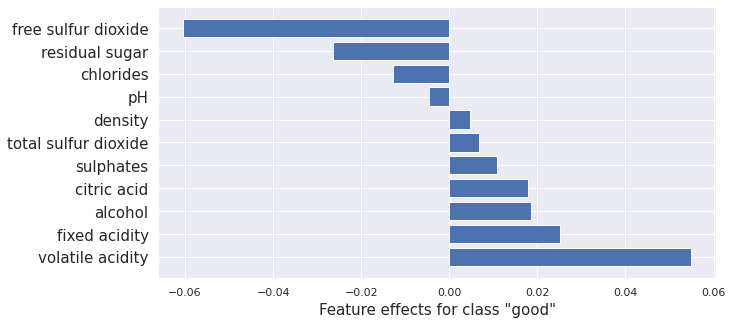

In [14]:
from alibi.explainers import IntegratedGradients

ig = IntegratedGradients(model,
                         layer=None,
                         method="gausslegendre",
                         n_steps=50,
                         internal_batch_size=100)

result = ig.explain(scaler.transform(x), target=0)

plot_importance(result.data['attributions'][0], features, '"good"')

### Kernel SHAP

Kernel SHAP is a method for computing the Shapley values of a model around an instance. Shapley values are a game-theoretic method of assigning payout to players depending on their contribution to an overall goal. In our case, the features are the players, and the payouts are the attributions.

Here we give an example of Kernel SHAP method applied to the Tensorflow model.

100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


(<AxesSubplot:xlabel='Feature effects for class 0'>,
 <Figure size 720x360 with 1 Axes>)

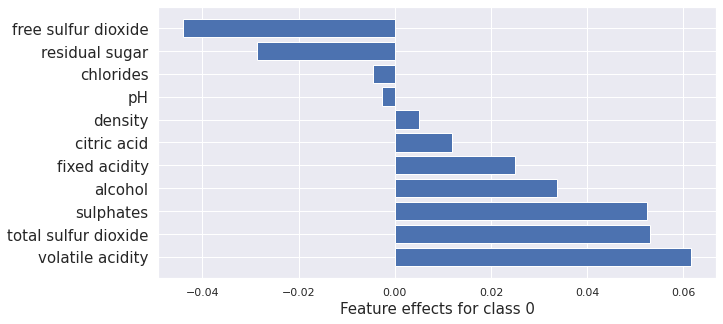

In [15]:
from alibi.explainers import KernelShap

predict_fn = lambda x: model(scaler.transform(x))

explainer = KernelShap(predict_fn, task='classification')

explainer.fit(X_train[0:100])

result = explainer.explain(x)

plot_importance(result.shap_values[0], features, 0)

Here we apply Kernel SHAP to the Tree-based model to compare to the tree-based methods we run later.

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


(<AxesSubplot:xlabel='Feature effects for class "Good"'>,
 <Figure size 720x360 with 1 Axes>)

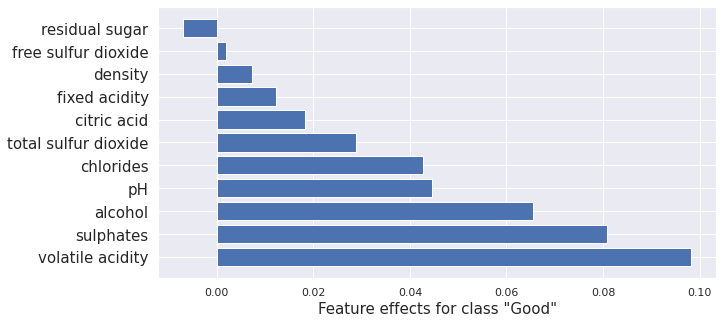

In [16]:
from alibi.explainers import KernelShap

predict_fn = lambda x: rfc.predict_proba(scaler.transform(x))

explainer = KernelShap(predict_fn, task='classification')

explainer.fit(X_train[0:100])

result = explainer.explain(x)

plot_importance(result.shap_values[1], features, '"Good"')

### Interventional treeSHAP

Interventional tree SHAP computes the same Shapley values as the kernel SHAP method above. The difference is that it's much faster for tree-based models. Here it is applied to the random forest we trained. Comparison with the kernel SHAP results above show very similar outcomes.

(<AxesSubplot:xlabel='Feature effects for class "Good"'>,
 <Figure size 720x360 with 1 Axes>)

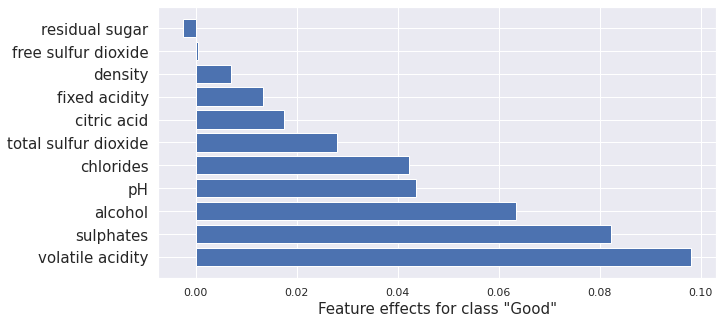

In [17]:
from alibi.explainers import TreeShap

tree_explainer_interventional = TreeShap(rfc, model_output='raw', task='classification')
tree_explainer_interventional.fit(scaler.transform(X_train[0:100]))
result = tree_explainer_interventional.explain(scaler.transform(x), check_additivity=False)

plot_importance(result.shap_values[1], features, '"Good"')

### Path Dependent treeSHAP

Path Dependent tree SHAP gives the same results as the Kernel SHAP method, only faster. Here it is applied to a random forest model. Again very similar results to kernel SHAP and Interventional tree SHAP as expected.

(<AxesSubplot:xlabel='Feature effects for class "Good"'>,
 <Figure size 720x360 with 1 Axes>)

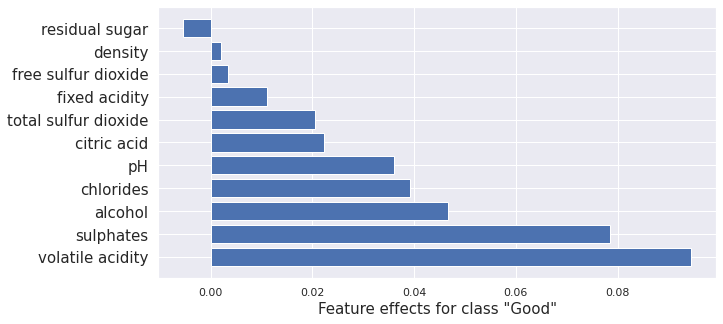

In [18]:
path_dependent_explainer = TreeShap(rfc, model_output='raw', task='classification')
path_dependent_explainer.fit()
result = path_dependent_explainer.explain(scaler.transform(x))

plot_importance(result.shap_values[1], features, '"Good"')

**Note**: There is some difference between the kernel SHAP and integrated gradient applied to the TensorFlow model and the SHAP methods applied to the random forest. This is expected due to the combination of different methods and models. They are reasonably similar overall. Notably, the ordering is nearly the same.

## Local Necessary Features

### Anchors

Anchors tell us what features need to stay the same for a specific instance for the model to give the same classification. In the case of a trained image classification model, an anchor for a given instance would be a minimal subset of the image that the model uses to make its decision.

Here we apply Anchors to the tensor flow model trained on the wine-quality dataset.

In [19]:
from alibi.explainers import AnchorTabular

predict_fn = lambda x: model.predict(scaler.transform(x))
explainer = AnchorTabular(predict_fn, features)
explainer.fit(X_train, disc_perc=(25, 50, 75))
result = explainer.explain(x, threshold=0.95)

The result is a set of predicates that tell you whether a point in the data set is in the anchor or not. If it is in the anchor, it is very likely to have the same classification as the instance `x`.

In [20]:
print('Anchor =', result.data['anchor'])
print('Precision = ', result.data['precision'])
print('Coverage = ', result.data['coverage'])

Anchor = ['alcohol > 10.10', 'volatile acidity <= 0.39']
Precision =  0.9555236728837877
Coverage =  0.16263552960800667


## Global Feature Attribution

### ALE 

ALE plots show the dependency of model output on a subset of the input features. They provide global insight describing the model's behaviour over the input space. Here we use ALE to directly visualize the relationship between the TensorFlow model's predictions and the alcohol content of wine.

array([[<AxesSubplot:xlabel='alcohol', ylabel='ALE'>]], dtype=object)

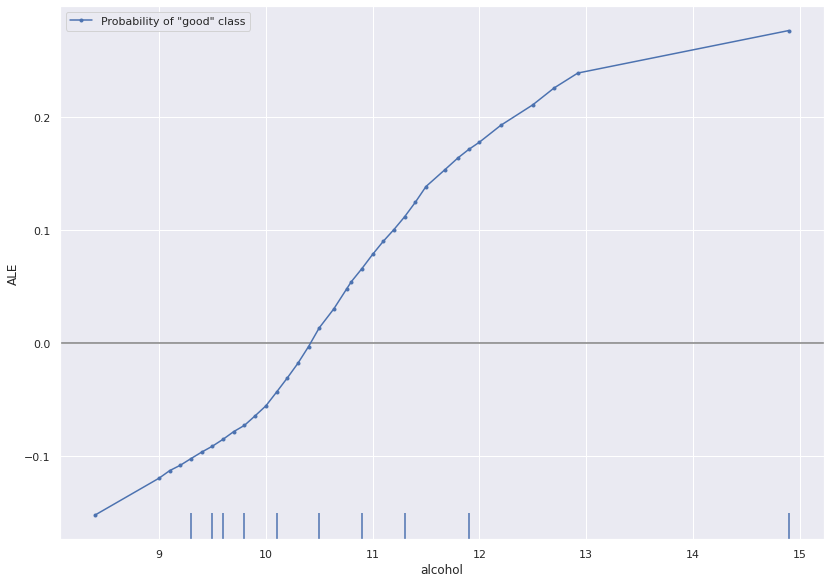

In [21]:
from alibi.explainers import ALE
from alibi.explainers.ale import plot_ale

predict_fn = lambda x: model(scaler.transform(x)).numpy()[:, 0]
ale = ALE(predict_fn, feature_names=features)
exp = ale.explain(X_train)
plot_ale(exp, features=['alcohol'], line_kw={'label': 'Probability of "good" class'})

## Counterfactuals

Next, we apply each of the "counterfactuals with reinforcement learning", "counterfactual instances", "contrastive explanation method", and the "counterfactuals with prototypes" methods. We also plot the kernel SHAP values to show how the counterfactual methods change the attribution of each feature leading to the change in prediction.

### Counter Factuals with Reinforcement Learning

CFRL trains a new model when fitting the explainer called an actor that takes instances and produces counterfactuals. It does this using reinforcement learning. In reinforcement learning, an actor model takes some state as input and generates actions; in our case, the actor takes an instance with a target classification and attempts to produce a member of the target class. Outcomes of actions are assigned rewards dependent on a reward function designed to encourage specific behaviors. In our case, we reward correctly classified counterfactuals generated by the actor. As well as this, we reward counterfactuals that are close to the data distribution as modeled by an autoencoder. Finally, we require that they are sparse perturbations of the original instance. The reinforcement training step pushes the actor to take high reward actions. CFRL is a black-box method as the process by which we update the actor to maximize the reward only requires estimating the reward via sampling the counterfactuals.

In [ ]:
from alibi.explainers import CounterfactualRL 

predict_fn = lambda x: model(x)

cfrl_explainer = CounterfactualRL(
    predictor=predict_fn,               # The model to explain
    encoder=ae.encoder,                 # The encoder
    decoder=ae.decoder,                 # The decoder
    latent_dim=7,                       # The dimension of the autoencoder latent space
    coeff_sparsity=0.5,                 # The coefficient of sparsity
    coeff_consistency=0.5,              # The coefficient of consistency
    train_steps=10000,                  # The number of training steps
    batch_size=100,                     # The batch size
)

cfrl_explainer.fit(X=scaler.transform(X_train))

result_cfrl = cfrl_explainer.explain(X=scaler.transform(x), Y_t=np.array([1]))
print("Instance class prediction:", model.predict(scaler.transform(x))[0].argmax())
print("Counterfactual class prediction:", model.predict(result_cfrl.data['cf']['X'])[0].argmax())

 70%|███████   | 7031/10000 [01:19<00:33, 89.83it/s]

In [ ]:
cfrl = scaler.inverse_transform(result_cfrl.data['cf']['X'])
compare_instances(x, cfrl)

In [ ]:
from alibi.explainers import KernelShap

predict_fn = lambda x: model(scaler.transform(x))

explainer = KernelShap(predict_fn, task='classification')

explainer.fit(X_train[0:100])

result_x = explainer.explain(x)
result_cfrl = explainer.explain(cfrl)

plot_importance(result_x.shap_values[0], features, 0)
plot_importance(result_cfrl.shap_values[0], features, 0)

### Counterfactual Instances

First we need to revert to using tfv1

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [ ]:
from tensorflow.keras.models import Model, load_model
model = load_tf_model() 
ae = load_ae_model()

The counterfactual instance method in alibi generates counterfactuals by defining a loss that prefers interpretable instances close to the target class. It then uses gradient descent to move within the feature space until it obtains a counterfactual of sufficient quality. 

In [ ]:
from alibi.explainers import Counterfactual

explainer = Counterfactual(
    model,                              # The model to explain
    shape=(1,) + X_train.shape[1:],     # The shape of the model input
    target_proba=0.51,                  # The target class probability
    tol=0.01,                           # The tolerance for the loss
    target_class='other',               # The target class to obtain  
)

result_cf = explainer.explain(scaler.transform(x))
print("Instance class prediction:", model.predict(scaler.transform(x))[0].argmax())
print("Counterfactual class prediction:", model.predict(result_cf.data['cf']['X'])[0].argmax())

In [ ]:
cf = scaler.inverse_transform(result_cf.data['cf']['X'])
compare_instances(x, cf)

In [ ]:
from alibi.explainers import KernelShap

predict_fn = lambda x: model.predict(scaler.transform(x))

explainer = KernelShap(predict_fn, task='classification')

explainer.fit(X_train[0:100])

result_x = explainer.explain(x)
result_cf = explainer.explain(cf)

plot_importance(result_x.shap_values[0], features, 0)
plot_importance(result_cf.shap_values[0], features, 0)

### Contrastive Explanations Method

The CEM method generates counterfactuals by defining a loss that prefers interpretable instances close to the target class. It also adds an autoencoder reconstruction loss to ensure the counterfactual stays within the data distribution.

In [ ]:
from alibi.explainers import CEM

cem = CEM(model,                            # model to explain
          shape=(1,) + X_train.shape[1:],   # shape of the model input
          mode='PN',                        # pertinant negative mode
          kappa=0.2,                        # Confidence parameter for the attack loss term
          beta=0.1,                         # Regularization constant for L1 loss term
          ae_model=ae                       # autoencoder model
)

cem.fit(
    scaler.transform(X_train), # scaled training data
    no_info_type='median'      # non-informative value for each feature
)
result_cem = cem.explain(scaler.transform(x), verbose=False)
cem_cf = result_cem.data['PN']

print("Instance class prediction:", model.predict(scaler.transform(x))[0].argmax())
print("Counterfactual class prediction:", model.predict(cem_cf)[0].argmax())

In [ ]:
cem_cf = result_cem.data['PN']
cem_cf = scaler.inverse_transform(cem_cf)
compare_instances(x, cem_cf)

In [ ]:
from alibi.explainers import KernelShap

predict_fn = lambda x: model.predict(scaler.transform(x))

explainer = KernelShap(predict_fn, task='classification')

explainer.fit(X_train[0:100])

result_x = explainer.explain(x)
result_cem_cf = explainer.explain(cem_cf)

plot_importance(result_x.shap_values[0], features, 0)
plot_importance(result_cem_cf.shap_values[0], features, 0)

### Counterfactual With Prototypes

Like the previous two methods, "counterfactuals with prototypes" defines a loss that guides the counterfactual towards the target class while also using an autoencoder to ensure it stays within the data distribution. As well as this, it uses prototype instances of the target class to ensure that the generated counterfactual is interpretable as a member of the target class.

In [ ]:
from alibi.explainers import CounterfactualProto

explainer = CounterfactualProto(
    model,                           # The model to explain
    shape=(1,) + X_train.shape[1:],  # shape of the model input
    ae_model=ae,                     # The autoencoder
    enc_model=ae.encoder             # The encoder
)

explainer.fit(scaler.transform(X_train)) # Fit the explainer with scaled data

result_proto = explainer.explain(scaler.transform(x), verbose=False)

proto_cf = result_proto.data['cf']['X']
print("Instance class prediction:", model.predict(scaler.transform(x))[0].argmax())
print("Counterfactual class prediction:", model.predict(proto_cf)[0].argmax())

In [ ]:
proto_cf = scaler.inverse_transform(proto_cf)
compare_instances(x, proto_cf)

In [ ]:
from alibi.explainers import KernelShap

predict_fn = lambda x: model.predict(scaler.transform(x))

explainer = KernelShap(predict_fn, task='classification')

explainer.fit(X_train[0:100])

result_x = explainer.explain(x)
result_proto_cf = explainer.explain(cem_cf)

plot_importance(result_x.shap_values[0], features, 0)
print(result_x.shap_values[0].sum())
plot_importance(result_proto_cf.shap_values[0], features, 0)
print(result_proto_cf.shap_values[0].sum())

Looking at the ALE plots below, we can see how the counterfactual methods change the features to flip the prediction. Note that the ALE plots potentially miss details local to individual instances as they are global insights.

In [ ]:
plot_ale(exp, features=['sulphates', 'alcohol', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide'], line_kw={'label': 'Probability of "good" class'})